In [20]:
from Interval import *
import cv2
import json
import concurrent.futures
from itertools import repeat

In [2]:
with open('obstacles.json') as f:   
    data = json.load(f)
obstacles = []
for obstacle in data['obstacles']:
    params,center = obstacle['params'],obstacle['center']
    obstacles.append(Interval(*params,center))

In [33]:
class Robot(Interval):
    radius = 30
    bot_color = 'b'
    color = 'blue'
    Δt = 1
    obstacles = None
    path = None
    Nr = 5
    Ntheta = 5
    
    def __init__(self,x_bot,y_bot,yaw,vi,vj,wi,wj):
        
        self.x_bot = x_bot
        self.y_bot = y_bot
        self.yaw = yaw
        self.vi = vi
        self.vj = vj
        self.wi = wi
        self.wj = wj
        self.theta1 = yaw
        self.theta2 = yaw + (wi - wj)*self.Δt
        self.origin = (x_bot+self.radius*(np.cos(self.theta1)+np.cos(self.theta2))/(1e-6 + np.sin(self.theta1-self.theta2)),
                       y_bot+self.radius*(np.sin(self.theta1)+np.sin(self.theta2))/(1e-6 + np.sin(self.theta1-self.theta2)))
        self.r1 = 0
        self.r2 = (vi-vj)*self.Δt
        n = self.radius/np.sin(1e-6+(self.theta2-self.theta1)/2)
        self.nu1 = n - self.radius
        self.nu2 = n + self.radius + self.r2
        super(Robot,self).__init__(self.nu1,self.nu2,self.theta1,self.theta2,self.origin)
    
    def collision_detection(self):
        Js = []
        #### maybe multiprocessing here
#         with concurrent.futures.ProcessPoolExecutor() as executor:
#             Js = [executor.submit(super(Robot,self).interval_analysis,obstacle,5,5)for obstacle in self.obstacles]
            
#         for f in concurrent.futures.as_completed(Js):
#             print(f)
        for obstacle in self.obstacles:
            Js.append(super(Robot,self).interval_analysis(obstacle,5,5))
        return Js
    
    def collision_avoidance(self,v,w,Js):
        """
        gives good v,w given bad v,w from the tracker
        """
        
        r,theta = v*self.Δt,w*self.Δt #bad r,theta
        p = Point(tuple(np.array(self.origin) + np.array([r*np.cos(theta),r*np.sin(theta)])))
        for J in Js:
            if p in J:
                break
        else:
            return v,w
        return self.collision_avoidance(v,J.theta1/self.Δt)    
            
        
    
#     def __iter__(self):
#         return self
    
#     def __next__(self):
#         pose = [self.x_bot,self.y_bot,self.yaw]
#         x_bot_new = self.x_bot + (self.vi-self.vj)*np.cos(self.yaw)*self.Δt
#         y_bot_new = self.y_bot + (self.vi-self.vj)*np.sin(self.yaw)*self.Δt
#         yaw_new = self.yaw + (self.wi-self.wj)*self.Δt
#         collision,J = collision_detection(self)
#         if not collision:
#             self.x_bot = x_bot_new
#             self.y_bot = y_bot_new
#             self.yaw = yaw_new
            
#         else:
#             pass
#             #cook something that creates new v,w which do not crash into the obstacles 
        
#         return Robot(*pose,self.vi,self.vj,self.wi,self.wj)
            
        
        
    def plot(self,ax):
        bot_circle = plt.Circle( (self.x_bot, self.y_bot),self.radius,color=self.bot_color)
        arrow = ax.arrow(self.x_bot,self.y_bot,self.radius*np.cos(self.yaw),self.radius*np.sin(self.yaw))
        patch = ax.add_patch(bot_circle)
        return [bot_circle,arrow]
                           
    def plot_interval(self,ax):
        return super(Robot,self).draw(ax,self.color)
    
    @classmethod
    def set_environment(cls,obstacles):
        cls.obstacles = obstacles
    @classmethod
    def set_path(cls,path):
        cls.path = path    

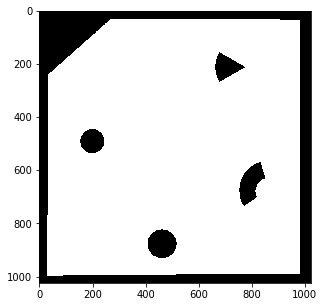

In [4]:
arena = cv2.imread("arena1.png")
arena = (1-cv2.cvtColor(arena,cv2.COLOR_RGB2GRAY)/255).astype('int')
fig,ax = plt.subplots(figsize=(5,5))
ax.imshow(arena,cmap = plt.cm.gray_r)

In [4]:
robot = Robot(500,500,0,100,0,0.5235,0)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
i = 0
for pose in robot:
    i+=1
    pose.plot(ax)
    pose.plot_interval(ax)
    del pose
    if i == 15:
        break

NameError: name 'Robot' is not defined

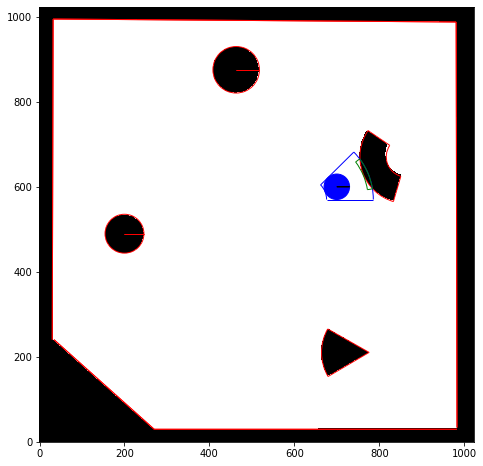

In [35]:

    
robot = Robot(700,600,0,50,0,0.78,0)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for obstacle in obstacles:
    obstacle.draw(ax,'red')
robot.plot(ax)
robot.plot_interval(ax)
robot.set_environment(obstacles)
Js = robot.collision_detection()
for J in Js:
    J.draw(ax,'green')


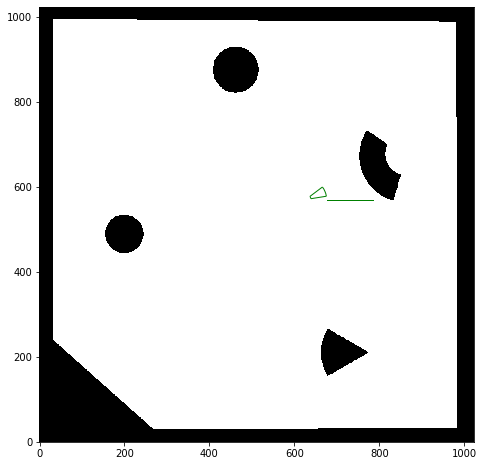

In [37]:
comps = robot.complement_intervals(Js)

fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for comp in comps:
    comp.draw(ax,'green')

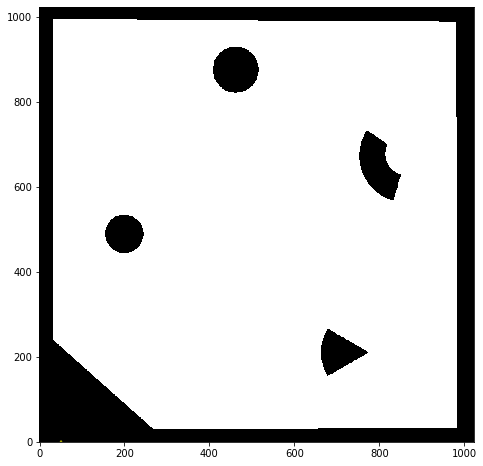

In [28]:
robot = Robot(700,600,0,50,0,0.78,0)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(arena,cmap = plt.cm.gray_r,origin = 'lower')
for J in Js:
    J.draw(ax,'yellow')

In [23]:
robot.obstacles

In [5]:
p = Point(2,3.5)
#np.array(p)
p[0]

2